## Setup

In [1]:
import os
import csv
import json
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_ranking as tfr

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
import glob
import librosa

In [3]:
import tensorflow_io as tfio

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-08-07 01:29:06.000769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 01:29:06.037324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.040705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.041054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

True

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.345636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.345921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 9697 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)

In [5]:
data_dir_path = pathlib.Path('/home/jake/project/split')

In [6]:
aug = False

## Load Data

In [7]:
train_ds = tf.data.Dataset.list_files('/home/jake/project/split/train/*/*', shuffle=True)
test_ds = tf.data.Dataset.list_files('/home/jake/project/split/test/*/*', shuffle=True)
val_ds = tf.data.Dataset.list_files('/home/jake/project/split/val/*/*', shuffle=False)

2022-08-07 01:29:06.383023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.383456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.383793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.384398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 01:29:06.384732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [8]:
train_path = pathlib.Path('/home/jake/project/split/train/')

In [9]:
class_names = np.array(sorted([item.name for item in train_path.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['cough' 'laughter' 'sigh' 'sneeze' 'sniff' 'throatclearing']


## Define Data Pipeline Functions

In [10]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [11]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [12]:
def preprocess(file_path):
    label = get_label(file_path)
    wav = load_wav_16k_mono(file_path)
    wav = wav[:80000]
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    stfts = tf.signal.stft(wav, frame_length=1024 , frame_step=256)
    spectrograms = tf.abs(stfts)
    num_spectrogram_bins = 513
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000, 128
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
        linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spec = tf.math.log(mel_spectrograms + 1e-6)
    log_mel_spectrogram = tf.expand_dims(log_mel_spec, axis=2)
    return log_mel_spectrogram, label

### Test Data Pipeline

In [13]:
for x in train_ds.take(1):
    print(x.numpy())

b'/home/jake/project/split/train/laughter/m2717_0_laughter.wav'


In [14]:
test_path = '/home/jake/project/split/train/sigh/m0577_0_sigh.wav'

In [15]:
test_path = '/home/jake/project/split/train/sneeze/f3344_0_sneeze.wav'

In [16]:
test_path = '/home/jake/project/split/train/throatclearing/m1663_0_throatclearing.wav'

In [17]:
test_path = '/home/jake/project/split/train/laughter/m1231_0_laughter.wav'

In [18]:
spectrogram, label = preprocess(test_path)

2022-08-07 01:29:06.615977: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-08-07 01:29:07.195506: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


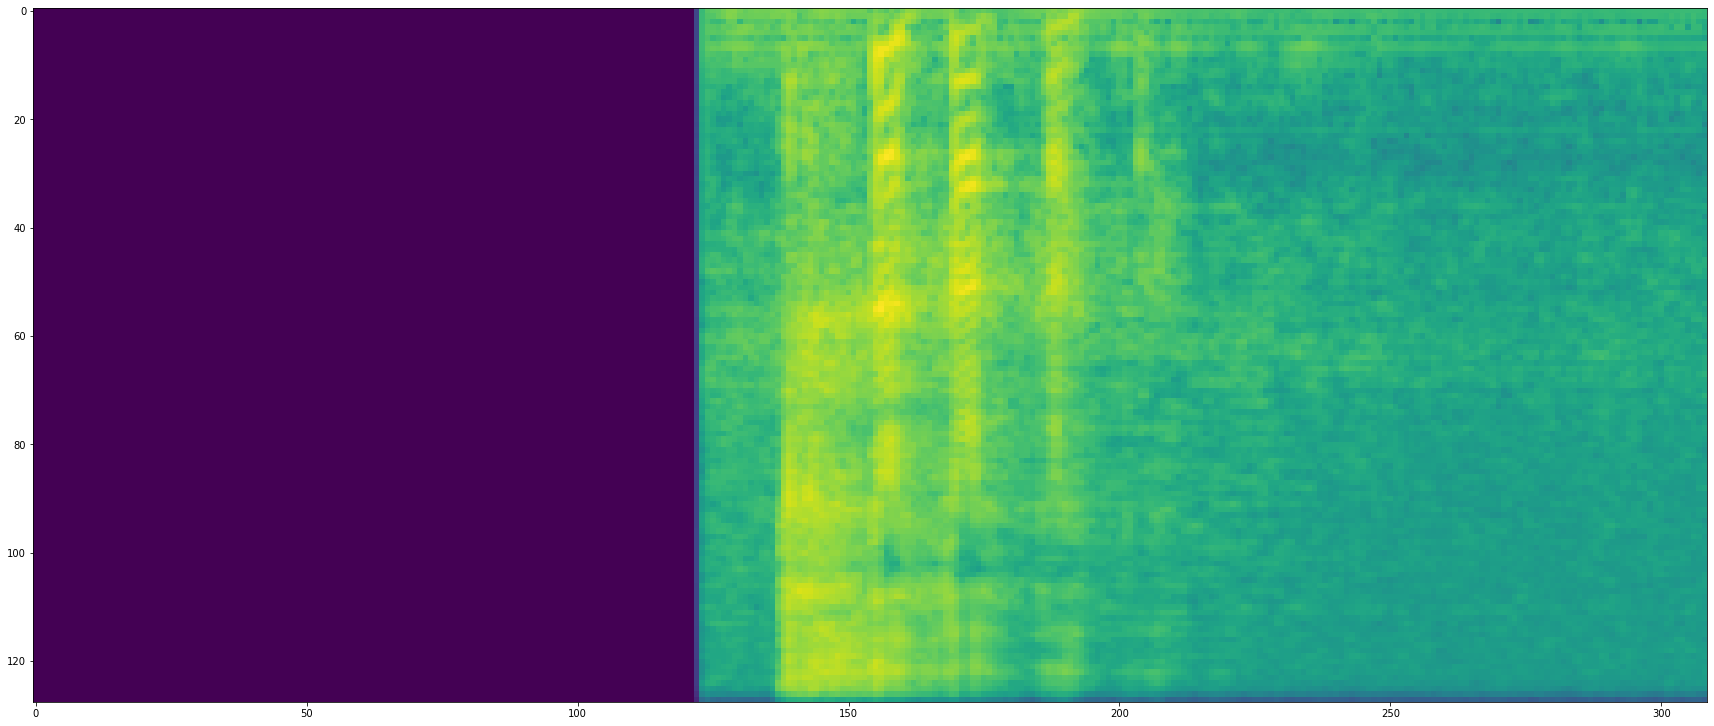

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Look at lengths of our spectrograms
#### We will use this to adjust zero paddding

In [20]:
look_at_lengths = False
if look_at_lengths == True:
    files = glob.glob('/home/jake/project/split/*/*/*')
    lengths = []
    for file in files:
        tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
        lengths.append(len(tensor_wave))
    print(tf.math.reduce_mean(lengths))
    print(tf.math.reduce_min(lengths))
    print(tf.math.reduce_max(lengths))

### Process Dataset

In [21]:
def configure_ds(dataset, val=False):
    dataset = dataset.map(preprocess)
    if val==False:
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.prefetch(8)
    dataset = dataset.batch(32)
    return dataset

In [22]:
train_ds = configure_ds(train_ds)
test_ds = configure_ds(test_ds)
val_ds = configure_ds(val_ds, val=True)

#### Look at shape of data in batch

In [23]:
samples, labels = train_ds.as_numpy_iterator().next()

In [24]:
samples.shape

(32, 309, 128, 1)

In [25]:
labels.shape

(32,)

In [26]:
specLen = samples.shape[1]

### Build Model

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import Layer

#### set hyperparameters

In [28]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 50
image_size = 144  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [29]:
class SpecAugment(Layer):
    """
    Implementation of a layer that contains the SpecAugment Transformation
    """

    def __init__(self,
                 freq_mask_param: int,
                 time_mask_param: int,
                 n_freq_mask: int = 1,
                 n_time_mask: int = 1,
                 mask_value: float = 0.
                 ):
        """
        :param freq_mask_param: Frequency Mask Parameter (F in the paper)
        :param time_mask_param: Time Mask Parameter (T in the paper)
        :param n_freq_mask: Number of frequency masks to apply (mF in the paper). By default is 1.
        :param n_time_mask: Number of time masks to apply (mT in the paper). By default is 1.
        :param mask_value: Imputation value. By default is zero.
        """
        super(SpecAugment, self).__init__(name="SpecAugment")
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.n_freq_mask = n_freq_mask
        self.n_time_mask = n_time_mask
        self.mask_value = tf.cast(mask_value, tf.float32)

    def _frequency_mask_single(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        n_mels = tf.cast(tf.shape(input_mel_spectrogram)[1], tf.float32)
        freq_indices = tf.reshape(tf.cast(tf.range(n_mels), tf.int32), (1, -1, 1))

        # We use the paper's notation
        f = tf.cast(tf.random.uniform(shape=(), maxval=self.freq_mask_param), tf.int32)
        f0 = tf.cast(tf.random.uniform(shape=(), maxval=n_mels - tf.cast(f, tf.float32)), tf.int32)

        condition = tf.logical_and(freq_indices >= f0, freq_indices <= f0 + f)
        return tf.cast(condition, tf.float32)

    def _frequency_masks(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        mel_repeated = tf.repeat(tf.expand_dims(input_mel_spectrogram, 0), self.n_freq_mask, axis=0)
        masks = tf.cast(tf.map_fn(elems=mel_repeated, fn=self._frequency_mask_single), tf.bool)
        mask = tf.math.reduce_any(masks, 0)
        return tf.where(mask, self.mask_value, input_mel_spectrogram)

    def _time_mask_single(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        n_steps = tf.cast(tf.shape(input_mel_spectrogram)[0], tf.float32)
        time_indices = tf.reshape(tf.cast(tf.range(n_steps), tf.int32), (-1, 1, 1))

        # We use the paper's notation
        t = tf.cast(tf.random.uniform(shape=(), maxval=self.time_mask_param), tf.int32)
        t0 = tf.cast(tf.random.uniform(shape=(), maxval=n_steps - tf.cast(t, tf.float32)), tf.int32)

        condition = tf.logical_and(time_indices >= t0, time_indices <= t0 + t)
        return tf.cast(condition, tf.float32)

    def _time_masks(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        mel_repeated = tf.repeat(tf.expand_dims(input_mel_spectrogram, 0), self.n_time_mask, axis=0)
        masks = tf.cast(tf.map_fn(elems=mel_repeated, fn=self._time_mask_single), tf.bool)
        mask = tf.math.reduce_any(masks, 0)
        return tf.where(mask, self.mask_value, input_mel_spectrogram)

    def _apply_spec_augment(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        if self.n_freq_mask >= 1:
            input_mel_spectrogram = self._frequency_masks(input_mel_spectrogram)
        if self.n_time_mask >= 1:
            input_mel_spectrogram = self._time_masks(input_mel_spectrogram)
        return input_mel_spectrogram

    def call(self, inputs: tf.Tensor, training=None, **kwargs):
        """
        Applies the SpecAugment operation to the input Mel Spectrogram
        :param inputs: The input mel spectrogram
        :param training: If True then it will be applied
        :return: A mel spectrogram after the time and frequency are applied
        """
        if training:
            inputs_masked = tf.map_fn(elems=inputs, fn=self._apply_spec_augment)
            return inputs_masked
        return inputs

    def get_config(self):
        """
        Generates a description of the parameters selected. It uses the notation in the paper
        :return:
        """
        config = {
            "freq_mask_param": self.freq_mask_param,
            "time_mask_param": self.time_mask_param,
            "n_freq_mask": self.n_freq_mask,
            "n_time_mask": self.n_time_mask,
            "mask_value": self.mask_value.numpy(),
        }
        return config

In [30]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [31]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [32]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)

In [33]:
spec_augment = SpecAugment(freq_mask_param=5,
                           time_mask_param=10,
                           n_freq_mask=5,
                           n_time_mask=3,
                           mask_value=-100) 

In [34]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [35]:
def create_vit_classifier():
    inputs = layers.Input(shape=(311, 128, 1))
    # Augment data.
    augmented = data_augmentation(inputs)
    # specAug
    augmented = spec_augment(augmented)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(6)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [36]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
            #keras.metrics.AUC(name='auc'),
            #tfa.metrics.F1Score(name='F1',num_classes=6)
        ],
    )

    cwd = os.getcwd()
    model_dir = os.path.join(cwd,'models')
    this_model_dir = os.path.join(model_dir,f'8heads_newshapeT_specLen_{specLen}_aug_{aug}_mel_image_size_{image_size}_num_patches_{num_patches}_epochs_{num_epochs}')
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    if not os.path.exists(this_model_dir):
        os.mkdir(this_model_dir)
    checkpoint_filepath = os.path.join(this_model_dir,'cp.ckpt')
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_2_accuracy = model.evaluate(val_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/50
486/486 [==============================] - 86s 165ms/step - loss: 2.4235 - accuracy: 0.2190 - top-2-accuracy: 0.4065 - val_loss: 1.3554 - val_accuracy: 0.4773 - val_top-2-accuracy: 0.7176
Epoch 2/50
486/486 [==============================] - 80s 162ms/step - loss: 1.4776 - accuracy: 0.4103 - top-2-accuracy: 0.6276 - val_loss: 1.0753 - val_accuracy: 0.6015 - val_top-2-accuracy: 0.7895
Epoch 3/50
486/486 [==============================] - 79s 160ms/step - loss: 1.3235 - accuracy: 0.4853 - top-2-accuracy: 0.7006 - val_loss: 1.1826 - val_accuracy: 0.5862 - val_top-2-accuracy: 0.7600
Epoch 4/50
486/486 [==============================] - 80s 162ms/step - loss: 1.2255 - accuracy: 0.5352 - top-2-accuracy: 0.7401 - val_loss: 0.9917 - val_accuracy: 0.6775 - val_top-2-accuracy: 0.8519
Epoch 5/50
486/486 [==============================] - 80s 162ms/step - loss: 1.1466 - accuracy: 0.5758 - top-2-accuracy: 0.7705 - val_loss: 0.8562 - val_accuracy: 0.7023 - val_top-2-accuracy: 0.8624
Epoch

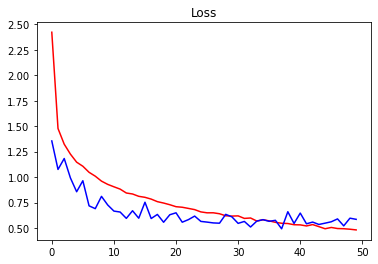

In [37]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

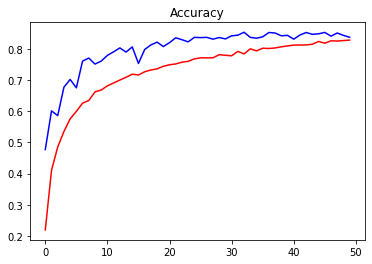

In [38]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.show()

### Output

In [39]:
import pickle
import csv

In [40]:
cwd = os.getcwd()
model_dir = os.path.join(cwd,'models')
this_model_dir = os.path.join(model_dir,f'8heads_newshapeT_specLen_{specLen}_aug_specAug_image_size_{image_size}_num_patches_{num_patches}_epochs_{num_epochs}')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(this_model_dir):
    os.mkdir(this_model_dir)
with open(os.path.join(this_model_dir,'history.pkl'), 'wb') as f:
    pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

## Results

In [ ]:
cwd = os.getcwd()
model_dir = os.path.join(cwd,'models')
this_model_dir = os.path.join(model_dir,f'cnn')
checkpoint_filepath = os.path.join(this_model_dir,'cp.ckpt')
model = create_vit_classifier()

model.load_weights(checkpoint_filepath)
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

### Confusion Matrix

In [ ]:
labels = np.concatenate([y for x, y in val_ds], axis=0)
probs=model.predict(val_ds) 
predictions=np.argmax(probs,axis=1)
tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

In [ ]:
# Data handling
import pandas as pd

# Exploratory Data Analysis & Visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix


# Plotting confusion matrix
matrix = pd.DataFrame((metrics.confusion_matrix(labels, predictions)), 
                      class_names, 
                      class_names)
print(matrix)

# Visualising confusion matrix
plt.figure(figsize = (8,8),facecolor='white')
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap=sns.cm.rocket_r,cbar=False)#cmap = 'YlGnBu'
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = 18, weight='bold')

plt.title('CNN Confusion Matrix\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.savefig(os.path.join(this_model_dir,'confusion_matrix.png'))
plt.show()

### Calculate mAP

In [ ]:
from sklearn.metrics import average_precision_score
ap_sum = 0
for label in set(labels):
    y_true = [1 if x == label else 0 for x in labels]
    y_prob = probs[:,label]
    print(y_true)
    print(y_prob)
    ap_sum += average_precision_score(y_true, y_prob)
mAP = ap_sum/6
print(mAP)